In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torchvision.models import mobilenet_v2
import os
import matplotlib.pyplot as plt
import numpy as np

# Define dataset path
data_dir = "C:\\Users\\amogh\\OneDrive\\Documents\\GitHub\\EPOCH-2.0\\realwaste-main\RealWaste"  # Change this to your dataset location

# Define transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Reduce image size for faster processing
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = dataset.classes  # Class names

# Split into training (80%) and validation (20%)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders with optimized settings for CPU training
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=True)

# Load Pretrained MobileNetV2 model
model = mobilenet_v2(pretrained=True)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, len(class_names))  # Adjust output layer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=1):  # Reduced to 1 epoch for speed
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
        
        train_acc = correct / total * 100
        print(f"Epoch {epoch+1}: Loss: {total_loss/len(train_loader):.4f}, Accuracy: {train_acc:.2f}%")
        
    print("Training complete!")

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=1)  # Only 1 epoch for speed

# Validation accuracy
def evaluate_model(model, val_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    print(f"Validation Accuracy: {correct / total * 100:.2f}%")

evaluate_model(model, val_loader)


<>:13: SyntaxWarning: invalid escape sequence '\R'
<>:13: SyntaxWarning: invalid escape sequence '\R'
C:\Users\amogh\AppData\Local\Temp\ipykernel_11100\3590479527.py:13: SyntaxWarning: invalid escape sequence '\R'
  data_dir = "C:\\Users\\amogh\\OneDrive\\Documents\\GitHub\\EPOCH-2.0\\realwaste-main\RealWaste"  # Change this to your dataset location
c:\Users\amogh\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\amogh\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Loss: 1.3268, Accuracy: 55.06%
Training complete!
Validation Accuracy: 60.78%


In [14]:
def visualize_predictions(model, dataloader, class_names, num_images=5):
    """
    Visualize images with their predictions and actual labels
    
    Args:
        model: trained PyTorch model
        dataloader: DataLoader containing images to visualize
        class_names: list of class names
        num_images: number of images to visualize
    """
    model.eval()
    images_shown = 0
    plt.figure(figsize=(15, 12))
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(1).cpu()
            
            for i in range(len(images)):
                if images_shown >= num_images:
                    plt.tight_layout()
                    plt.show()
                    return
                
                # Get the image and denormalize it
                img = images[i].cpu().numpy().transpose(1, 2, 0)
                # Denormalize from [-1, 1] back to [0, 1]
                img = img * 0.5 + 0.5
                
                # Get the true and predicted labels
                true_label = class_names[labels[i]]
                pred_label = class_names[preds[i]]
                
                # Set color for the title based on correct/incorrect prediction
                color = 'green' if pred_label == true_label else 'red'
                
                # Plot the image
                plt.subplot(1, num_images, images_shown + 1)
                plt.imshow(img)
                plt.axis('off')
                plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
                
                images_shown += 1
            
            if images_shown >= num_images:
                plt.tight_layout()
                plt.show()
                return

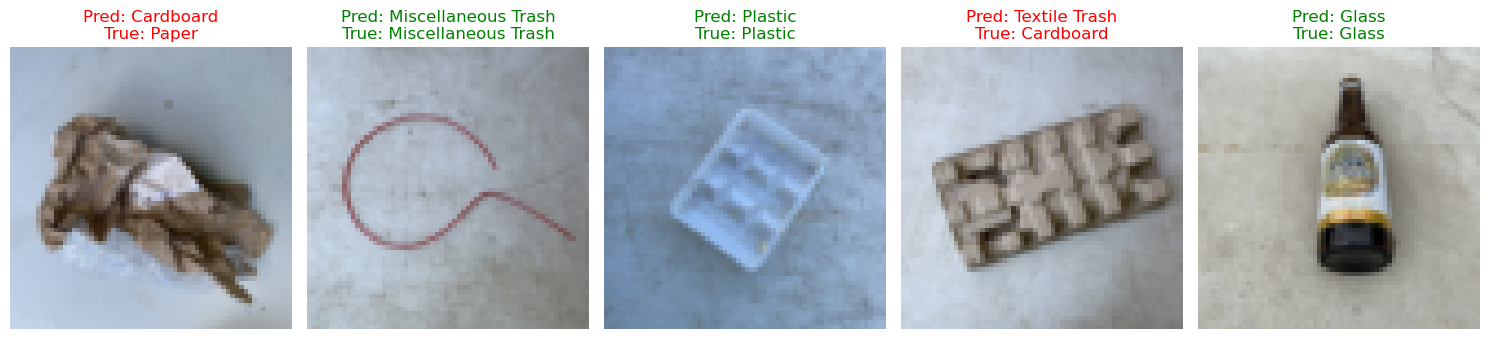

In [15]:
# Display predictions on some validation images
visualize_predictions(model, val_loader, class_names, num_images=5)